# 0. Libraries

In [21]:
# loading dataset, plotting
import pandas as pd
import matplotlib.pyplot as plt

# scaling dataset
from sklearn.preprocessing import MinMaxScaler

# preprocessing dataset (converting timestamp to numerical)
from datetime import datetime
from dateutil.parser import parse

# 1. Reading dataset

In [29]:
# loading csv dataset
dataset_path = "/content/drive/My Drive/Work/YapAiTek/Assessment/dataset/psi_df_2016_2019.csv"
df = pd.read_csv(dataset_path)

In [30]:
df.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


# 2. Preprocessing Dataset

adding year, month, day and hour to dataset

In [31]:
df['year'] = [row[1]['timestamp'][:4] for row in df.iterrows()]
df['month'] = [row[1]['timestamp'][5:7] for row in df.iterrows()]
df['day'] = [row[1]['timestamp'][8:10] for row in df.iterrows()]
df['hour'] = [row[1]['timestamp'][11:13] for row in df.iterrows()]

converting timestamp to numerical timestamp

In [32]:
timestamp = df['timestamp'].values
numerical_timestamp = []

# parsing string timestamp for each row
for i in timestamp:
  tp = parse(i).timestamp()
  dt = datetime.fromtimestamp(tp)
  numerical_timestamp.append(dt)

# dropping string timestamp from dataframe
df = df.drop('timestamp', 1)

# adding numerical timestamp to dataframe
df['timestamp'] = numerical_timestamp

In [33]:
df.head()

,national,south,north,east,central,west,year,month,day,hour,timestamp
0,47,44,37,47,47,34,2016,02,07,18,2016-02-07 10:00:00
1,59,57,54,59,57,56,2016,02,08,23,2016-02-08 15:00:00
2,59,57,55,59,57,56,2016,02,09,01,2016-02-08 17:00:00
3,59,57,55,59,56,56,2016,02,09,02,2016-02-08 18:00:00
4,59,58,55,59,56,56,2016,02,09,03,2016-02-08 19:00:00


Checking dataset for NaN values

In [34]:
df.isnull().values.any()

False

Setting Timestamps as index of dataframe

In [35]:
df = df.set_index('timestamp')

In [36]:
df.head()

,national,south,north,east,central,west,year,month,day,hour
timestamp,,,,,,,,,,
2016-02-07 10:00:00,47,44,37,47,47,34,2016,02,07,18
2016-02-08 15:00:00,59,57,54,59,57,56,2016,02,08,23
2016-02-08 17:00:00,59,57,55,59,57,56,2016,02,09,01
2016-02-08 18:00:00,59,57,55,59,56,56,2016,02,09,02
2016-02-08 19:00:00,59,58,55,59,56,56,2016,02,09,03


# 3. Plotting Data

plotting y vs x

In [45]:
y_labels = ['national', 'south', 'north', 'east', 'central', 'west']
y = [df['national'], df['south'], df['north'], df['east'], df['central'], df['west']]

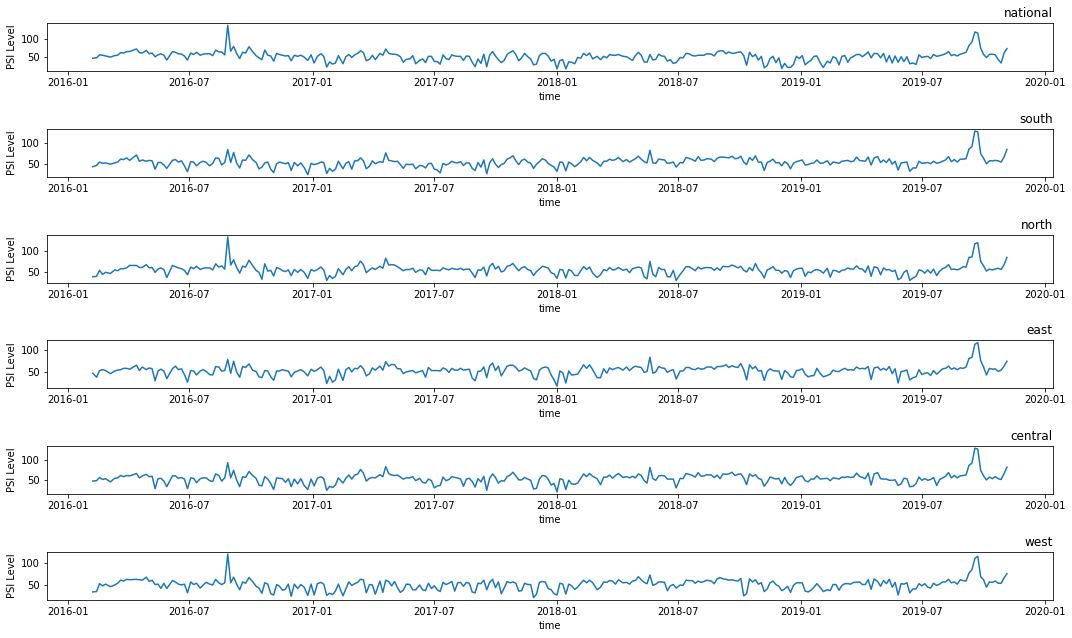

In [46]:
# plot each column
plt.figure(figsize=(15,10))
suplot_idx = 1

for i in range(6):
  fig = plt.subplot(7, 1, suplot_idx)
  plt.tight_layout()
  plt.plot(y[i][::100])
  plt.title(y_labels[i], y=0.5, loc='right')

  # set xlabel and ylabel
  plt.xlabel("time")
  plt.ylabel("PSI Level")

  suplot_idx += 1

plotting histogram

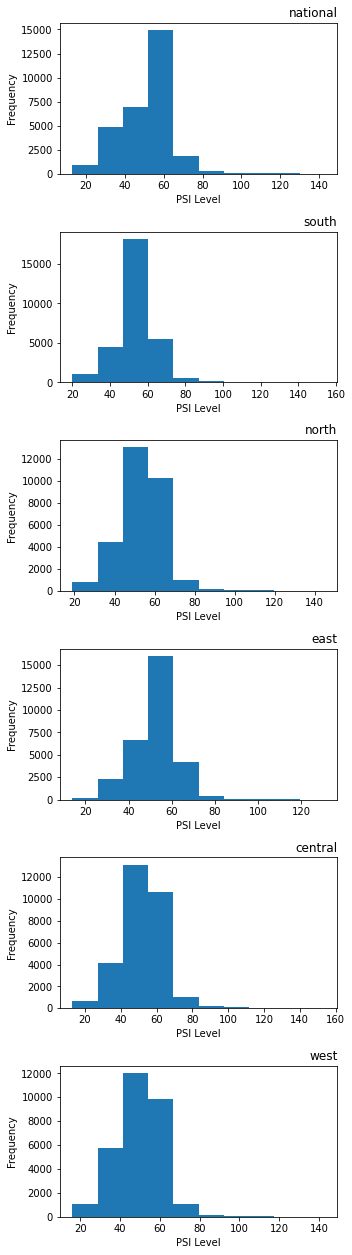

In [51]:
# plot each column
plt.figure(figsize=(5,20))
suplot_idx = 1

for i in range(6):
  fig = plt.subplot(7, 1, suplot_idx)
  plt.tight_layout()
  plt.hist(y[i])
  plt.title(y_labels[i], y=0.5, loc='right')

  # set xlabel and ylabel
  plt.xlabel("PSI Level")
  plt.ylabel("Frequency")

  suplot_idx += 1

Converting Series to a Supervised dataset

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
  Source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:

 
 
raw = pd.DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
print(values)
data = series_to_supervised(values, 1, 2)
print(data)

[[ 0 50]
 [ 1 51]
 [ 2 52]
 [ 3 53]
 [ 4 54]
 [ 5 55]
 [ 6 56]
 [ 7 57]
 [ 8 58]
 [ 9 59]]
   var1(t-1)  var2(t-1)  var1(t)  var2(t)  var1(t+1)  var2(t+1)
1        0.0       50.0        1       51        2.0       52.0
2        1.0       51.0        2       52        3.0       53.0
3        2.0       52.0        3       53        4.0       54.0
4        3.0       53.0        4       54        5.0       55.0
5        4.0       54.0        5       55        6.0       56.0
6        5.0       55.0        6       56        7.0       57.0
7        6.0       56.0        7       57        8.0       58.0
8        7.0       57.0        8       58        9.0       59.0
